In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import sys
sys.path.append('../python')
from functions import *
from models import *

import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

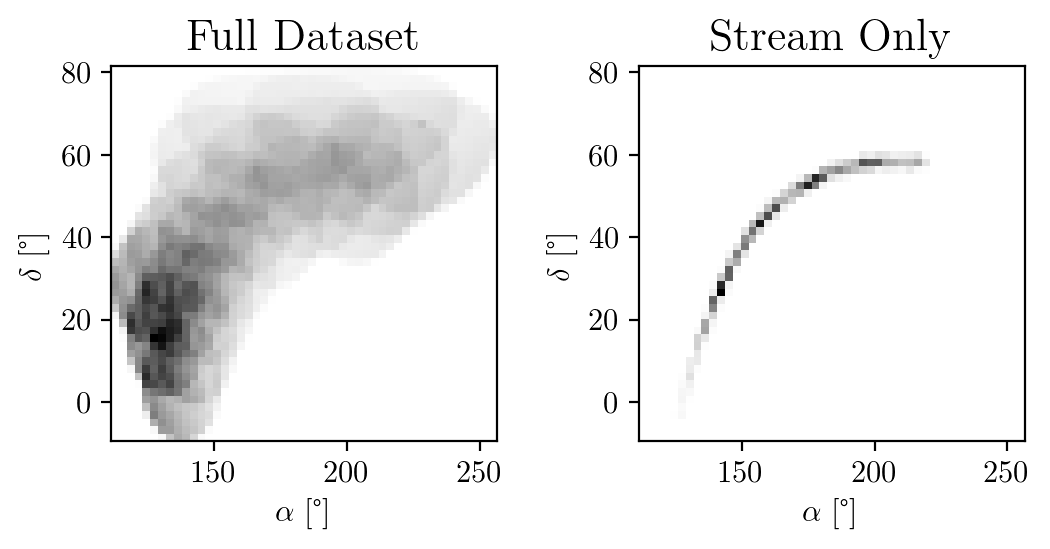

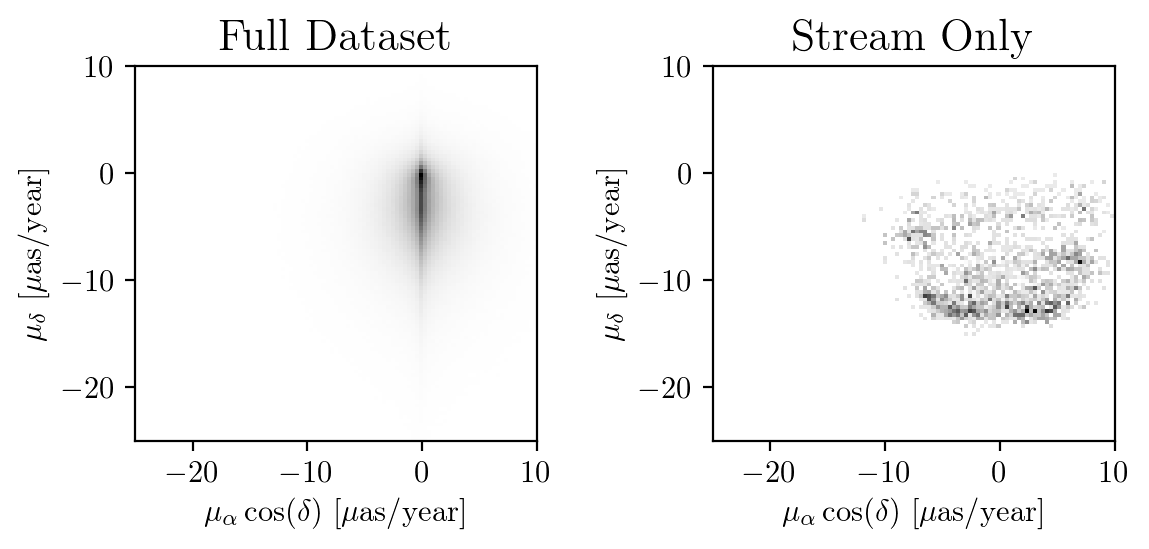

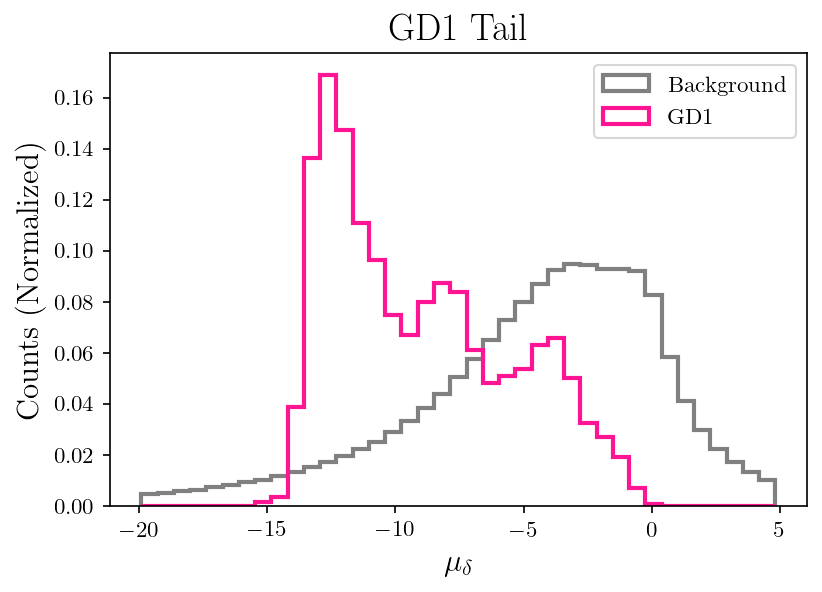

In [103]:
df_all = pd.read_hdf("../gaia_data/gd1/gd1_allpatches.h5")
visualize_stream(df_all)

In [40]:
#                    sb_min = -15,
#                    sr_min = -14,
#                    sr_max = -12, 
#                    sb_max = -11,

Problematic patches: 
(It seems like these all have a peak value of < 0.4 or so on the mu_delta_zoomed_in plot...)
- 2
- 6
- 7
- 8
- 9
- 10 
- 13
- 14
- 15
- 16
- 18
- 19
- 20

Good patches: 
[0, 1, 3, 4, 5, 11, 12, 17]

-13.29736339074042 -11.40806753533125 -9.329842094381165 -9.140912508840248


/clusterfs/ml4hep/mpettee/GaiaCWoLa/notebooks/../python/functions.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)
Loop: 100%|██████████| 3/3 [00:16<00:00,  5.53s/it]
/clusterfs/ml4hep/mpettee/GaiaCWoLa/notebooks/../python/models.py:128: RuntimeWarning: All-NaN axis encountered
  max_loop_purities = [np.nanmax(loop_purity) for loop_purity in loop_purities]


Max loop purities: [nan, 2.0, 4.0]
Best loop = 0, with a purity of 4.00%.
Loading weights from loop 0...
Top 50 stars: Purity = 4.0% 


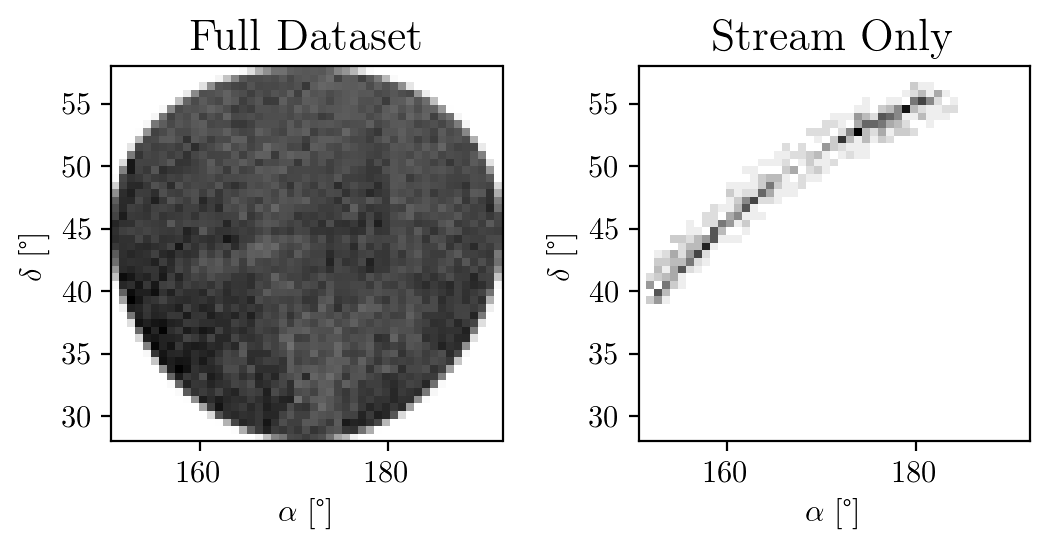

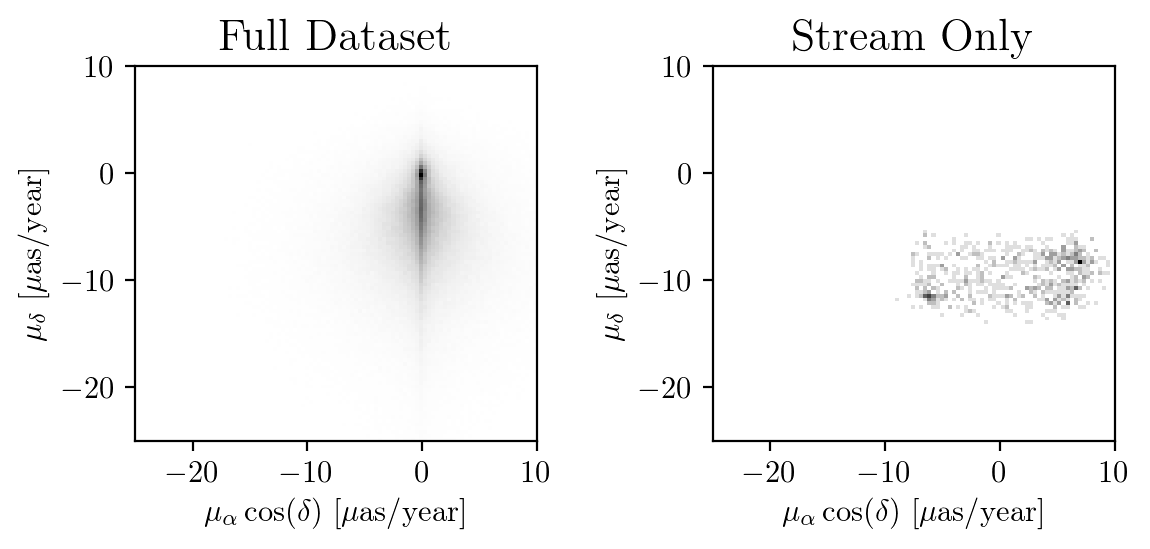

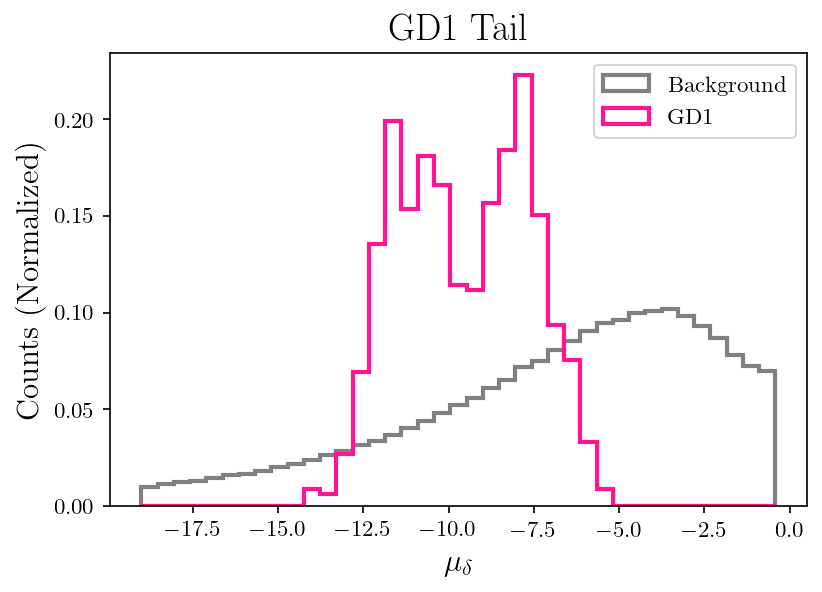

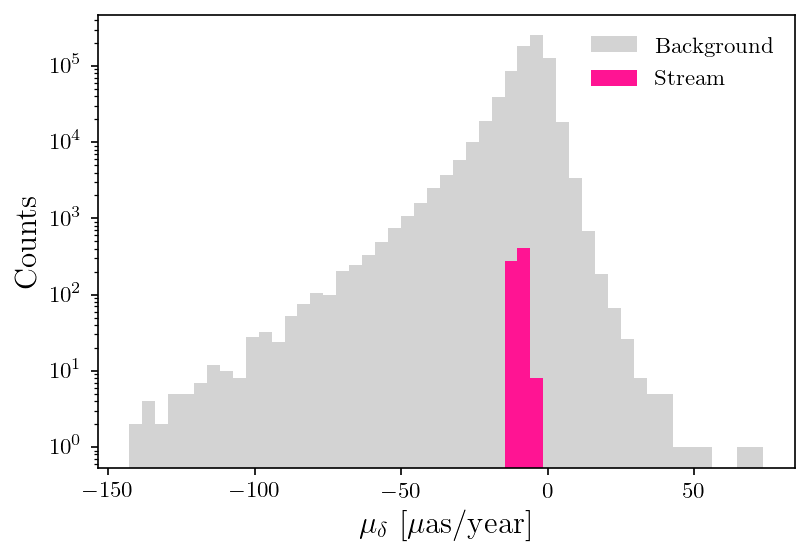

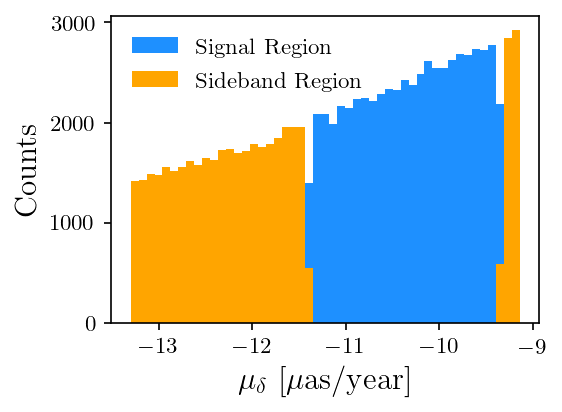

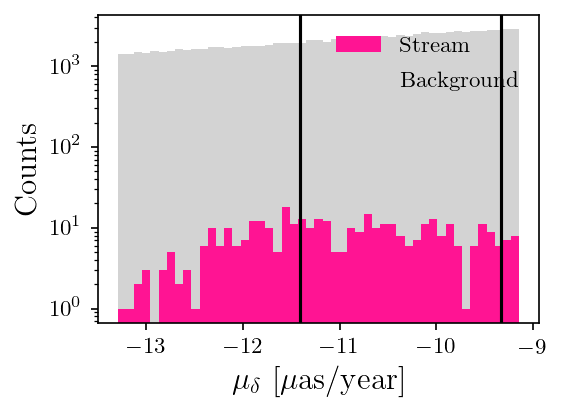

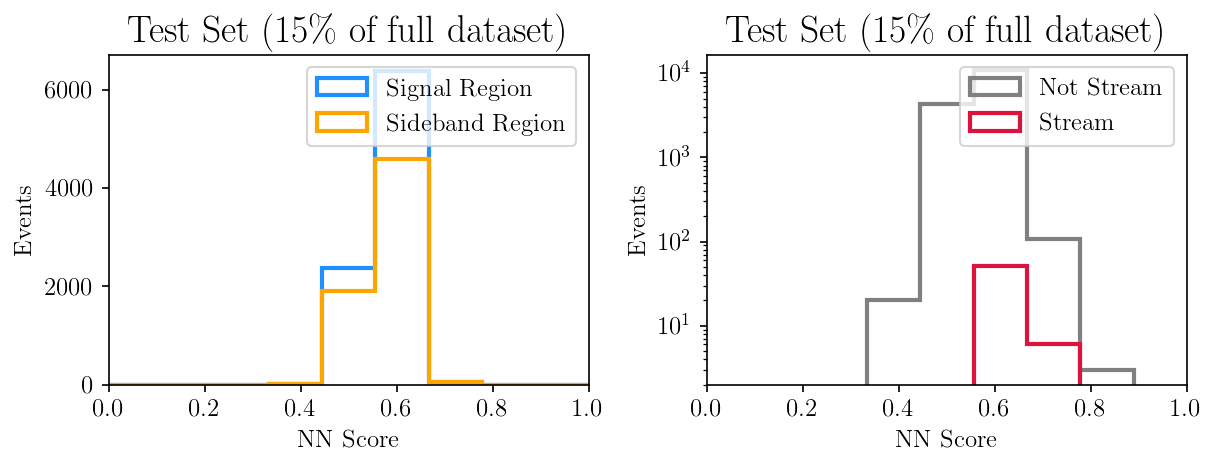

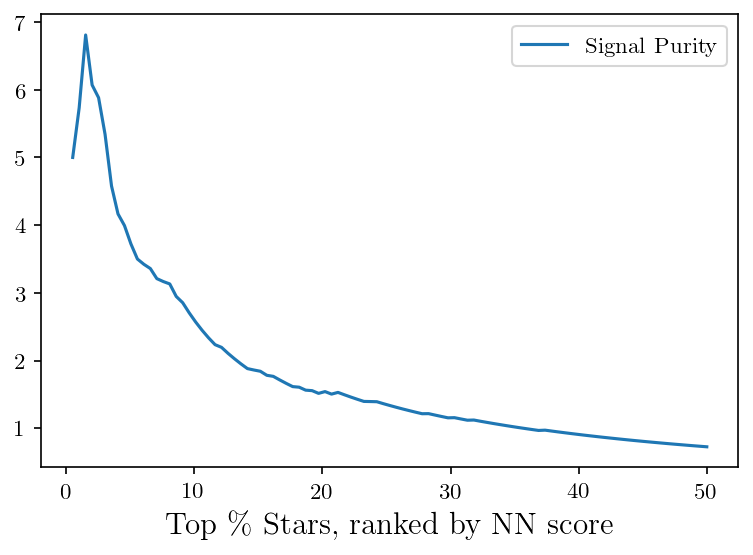

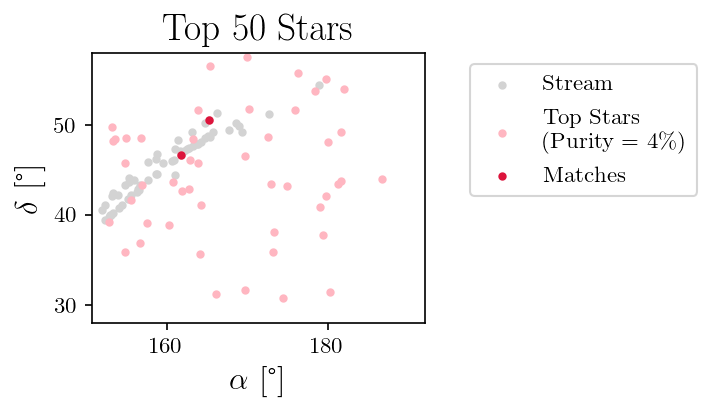

In [98]:
patch_id = 20

save_folder = os.path.join("./test")
df = df_all[df_all.patch_id == patch_id]
df = df.drop_duplicates(subset=['δ']) ### DROP DUPLICATES
visualize_stream(df, save_folder=save_folder+"/patches/patch{}".format(str(patch_id)))

sb_min = df[df.stream].μ_δ.mean()-2*df[df.stream].μ_δ.std()
sr_min = df[df.stream].μ_δ.mean()-1*df[df.stream].μ_δ.std()
sr_max = df[df.stream].μ_δ.mean()+0.1*df[df.stream].μ_δ.std()
sb_max = df[df.stream].μ_δ.mean()+0.2*df[df.stream].μ_δ.std()

# sb_min = -9
# sr_min = -8
# sr_max = -7
# sb_max = -6.9

print(sb_min, sr_min, sr_max, sb_max)

df_train = signal_sideband(df, save_folder=save_folder+"/patches/patch{}".format(str(patch_id)),
                sb_min = sb_min, sr_min = sr_min, sr_max = sr_max, sb_max = sb_max,
                verbose=False,
                )

tf.keras.backend.clear_session()
test = train(df_train, 
  n_folds = 1, 
  best_of_n_loops = 3,
  layer_size = 256, 
  batch_size = 15000, 
  dropout = 0.2, 
  l2_reg = 0,
  epochs = 20, 
  patience = 30,
  save_folder=save_folder+"/patches/patch{}".format(str(patch_id)),
  verbose = True,
)

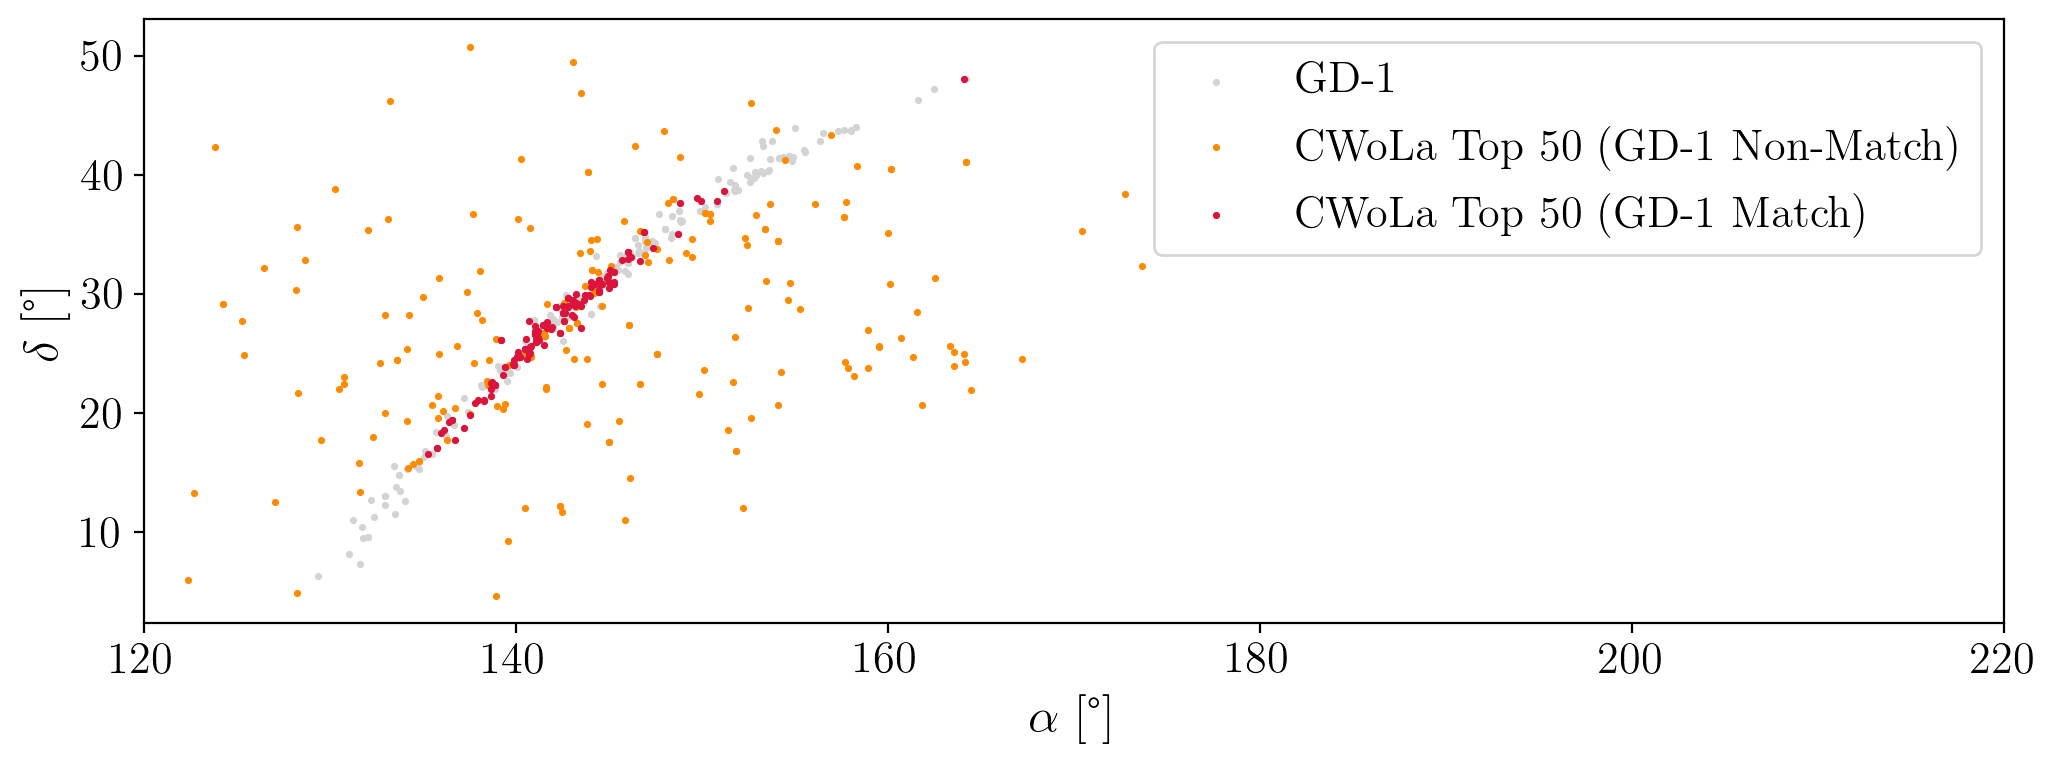

In [101]:
all_gd1_stars = []
cwola_stars = []

# files = sorted(glob(save_folder+"/patches/patch*/df_test.h5"))
files = sorted([save_folder+"/patches/patch{}/df_test.h5".format(index) for index in [0, 1, 3, 4, 5, 11, 12, 17]])

for file in files:
    test = pd.read_hdf(file)
    n_top_stars = np.min([len(test[test.stream]),50])
    patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
    all_gd1_stars.append(test[test.stream])
    cwola_stars.append(patch_top_stars)
    
all_gd1_stars = pd.concat([df for df in all_gd1_stars])
cwola_stars = pd.concat([df for df in cwola_stars])

plt.figure(dpi=200, figsize=(12,4))
plt.scatter(all_gd1_stars.α, all_gd1_stars.δ, marker='.', s=10, 
            color="lightgray", label="GD-1")
plt.scatter(cwola_stars[cwola_stars.stream == False].α, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=10, 
            color="darkorange", label="CWoLa Top 50 (GD-1 Non-Match)")
plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='.', s=10, 
            color="crimson", label="CWoLa Top 50 (GD-1 Match)")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\delta$ [\textdegree]", fontsize=18);
plt.xlim(120,220);
# plt.savefig("via_machinae_aps_50patches_top50.pdf", bbox_inches="tight");